<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 15th exercise: <font color="#C70039">Forecasting with Foundation Models: Prophet from Meta</font>
* Course: <a href="https://www.gernotheisenberg.de/time_series_forecasting.html">Time Series Forecasting (TSF)</a>
* Lecturer: <a href="https://www.gernotheisenberg.de/uebermich.html">Gernot Heisenberg</a>
* Date:   08.06.2025

<img src="./images/prophet.png" style="float: center;" width="450">

---------------------------------
**GENERAL NOTE 1**:
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole.

**GENERAL NOTE 2**:
* Please, when commenting source code, just use English language only.
* When describing an observation please use English language, too
* This applies to all exercises throughout this course.  

---------------------

### <font color="ce33ff">DESCRIPTION OF THE NOTEBOOK CONTENT</font>:
This notebook allows you for learning about how to forcast using your first foundation model, namely Prophet from Meta Inc.. You will be led through using Prophet step-by-step, so you will be able to use NeuralProphet (an open-source initiative and somehow second generation of Prophet) by yourself.

### <font color="FFC300">PROPHET INSTALLATION DETAILS FOR WINDOWS</font>:

If you are using a Windows machine, it is highly recommended that you use Anaconda
to perform any data science task. Trying to install Prophet through Anaconda the first
time might result in an error. This is because a compiler must be installed in order
for the package to function correctly on Windows.
If you are using Anaconda, you can run the following commands in your Anaconda prompt to install Prophet successfully:

* conda install libpython m2w64-toolchain -c msys2
* conda install numpy cython matplotlib scipy pandas -c conda-forge
* conda install -c conda-forge pystan (if it does not work try: pip install pystan)
* conda install -c conda-forge fbprophet (if it does not work try: pip install prophet)

If this does work with your env - then you are good.

If not, I recommend you to read this installation procedure:

https://blog.quantinsti.com/installing-prophet-library-windows/

-------------------------------------------------------------------------------------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points.
If a task is more challenging and consists of several steps, this is indicated as well.
Make sure you have worked down the task list and commented your doings.
This should be done by using markdown.<br>
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date.
    * set the date too and remove mine.
3. read the entire notebook carefully
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time.
    * understand the output
4. In exercise 9 we used a dataset that tracked the number of monthly air passengers in a given time period. You have developed a SARIMA model that achieved a MAPE of 2.85%.
5. Now, your task is to use Prophet to forecast the last 12 months of the dataset:
    * Does it make sense to add holiday effects?
    * Looking at the data, is the seasonality additive or multiplicative?
    * Use hyperparameter tuning and cross-validation to find the optimal parameters.
    * Fit the model with the optimal parameters and evaluate its predictions for the last 12 months. Does it achieve a lower MAPE?
-----------------------------------------------------------------------------------

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

In [27]:
# as always, set some useful parameters
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

## The data set

The data set contains the daily minimum temperature recorded in Melbourne from 1981 to 1991. There is a yearly seasonality, as expected, since it is hotter in the summer and colder in the winter (Melbourne !!!).

In [28]:
df = pd.read_csv('./data/FM/daily_min_temp.csv')

df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [29]:
df.tail()

,Date,Temp
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7
3649,1990-12-31,13.0


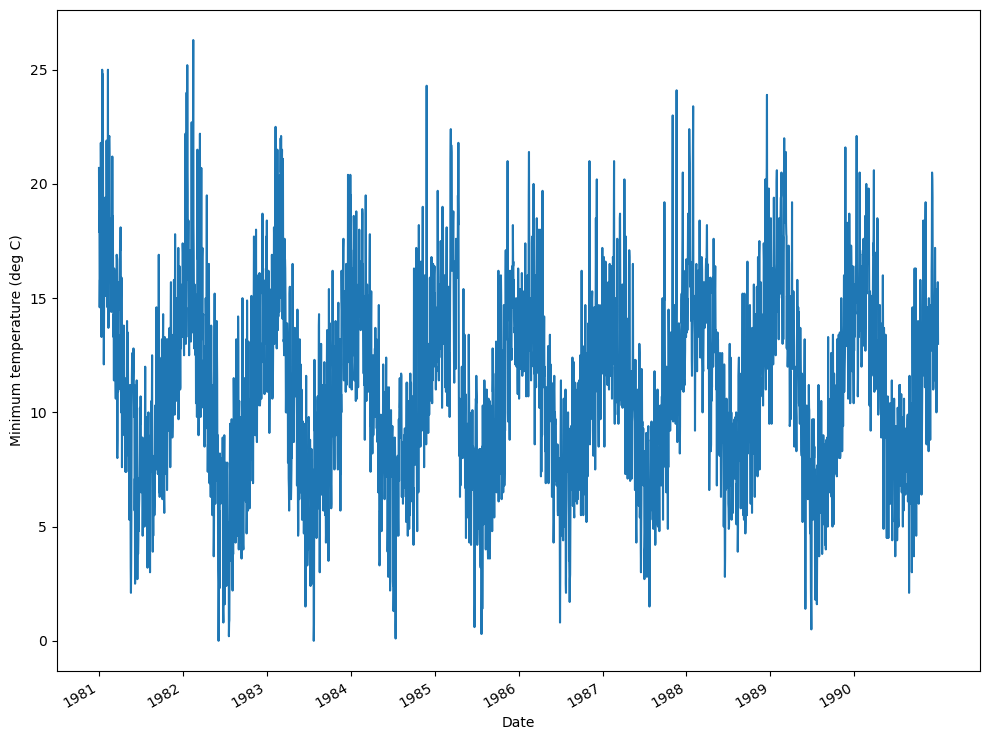

In [30]:
fig, ax = plt.subplots()

ax.plot(df['Temp'])
ax.set_xlabel('Date')
ax.set_ylabel('Minimum temperature (deg C)')

plt.xticks(np.arange(0, 3649, 365), np.arange(1981, 1991, 1))

fig.autofmt_xdate()
plt.tight_layout()

## Basic forecasting with Prophet

Prophet expects to have a DataFrame with two columns: 
* a date column named ds 
    * In a format accepted by pandas
    * Usually YYYY-MM-DD or YYYY-MM-DD HH:MM:SS.
* a value column named y

In [31]:
# Hence rename them into
df.columns = ['ds', 'y']
df.head()

,ds,y
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [32]:
# split off the last year for testing 
train = df[:-365]
test = df[-365:]

Prophet follows the sklearn API, where a model is initialized by creating an instance
of the Prophet class, the model is trained using the fit method and predictions are
generated using the predict method. Therefore, we’ll first initialize a Prophet model
by creating an instance of the Prophet class.

In [33]:
m = Prophet()

In [34]:
m.fit(train);

11:06:56 - cmdstanpy - INFO - Chain [1] start processing
11:06:57 - cmdstanpy - INFO - Chain [1] done processing


### <font color = red>NOTE</font>

If your were woundering about the (;) at the end of the code line above: 
'In interactive environments (such as Jupyter Notebooks), a semicolon at the end of a line is used to suppress automatic output.' 

Now, the next step is to create a DataFrame to hold the predictions from Prophet. 
We will use the make_future_dataframe method and specify the number of periods, which is
the number of days in our forecast horizon. In this case, we want 365 days of forecast,
so that they can be compared to the actual values observed in the test set.

In [35]:
future = m.make_future_dataframe(periods=365)

In [36]:
# All that is left to do is to generate the forecast using the predict method 
# and now we have a forecasting model in only four lines of code.
forecast = m.predict(future)

In [37]:
# print out the forecasting table. It contains a lot of information of which we are 
# interested in only the four values. 
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3645,1990-12-27,11.395572,11.179913,17.771946,11.302709,11.498934,3.043941,3.043941,3.043941,-0.026442,-0.026442,-0.026442,3.070383,3.070383,3.070383,0.0,0.0,0.0,14.439513
3646,1990-12-28,11.395473,11.001597,18.018697,11.301800,11.499328,3.121203,3.121203,3.121203,-0.009961,-0.009961,-0.009961,3.131165,3.131165,3.131165,0.0,0.0,0.0,14.516676
3647,1990-12-29,11.395374,11.096561,18.076197,11.300891,11.499722,3.145187,3.145187,3.145187,-0.048862,-0.048862,-0.048862,3.194050,3.194050,3.194050,0.0,0.0,0.0,14.540561
3648,1990-12-30,11.395275,10.733180,17.986811,11.300021,11.500117,3.069584,3.069584,3.069584,-0.188701,-0.188701,-0.188701,3.258285,3.258285,3.258285,0.0,0.0,0.0,14.464859
3649,1990-12-31,11.395177,11.533338,18.368461,11.299499,11.500511,3.366712,3.366712,3.366712,0.043652,0.043652,0.043652,3.323060,3.323060,3.323060,0.0,0.0,0.0,14.761888


Of the forcasting results dataFrame, we are essentially only interested in these four columns: 
* ds, yhat, yhat_lower, yhat_upper
* The ds column simply has the datestamp of the forecast. 
* The yhat column contains the value of the forecast, the prediction. 
* Prophet uses y for the actual value and yhat for the predicted value as a naming convention. 
* Consequently, yhat_lower and yhat_upper represent the lower and upper bounds of the 80% confidence interval of the prediction.
* This means that there is an 80% chance that the forecast will fall between yhat_lower and yhat_upper, with yhat being the value that we expect to obtain.


In [38]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-365:-360]

,ds,yhat,yhat_lower,yhat_upper
3285,1990-01-01,14.878268,11.173129,18.585734
3286,1990-01-02,15.004639,11.596726,18.287800
3287,1990-01-03,15.080976,11.461064,18.448442
3288,1990-01-04,14.988974,11.601138,18.461462
3289,1990-01-05,15.059176,11.667941,18.698761


In [39]:
# Now join test and forecast together, to create a single DataFrame holding both the actual and predicted values

test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
test.head()

,ds,y,yhat,yhat_lower,yhat_upper
3285,1990-01-01,14.8,14.878268,11.173129,18.585734
3286,1990-01-02,13.3,15.004639,11.596726,18.287800
3287,1990-01-03,15.6,15.080976,11.461064,18.448442
3288,1990-01-04,14.5,14.988974,11.601138,18.461462
3289,1990-01-05,14.3,15.059176,11.667941,18.698761


### Creation of the baseline (lastValue) to compare the model to and evaluate the performance of the model

In [40]:
# last year of the training set is repeated as the forecast for next year.
test['baseline'] = train['y'][-365:].values
test.head()

,ds,y,yhat,yhat_lower,yhat_upper,baseline
3285,1990-01-01,14.8,14.878268,11.173129,18.585734,14.3
3286,1990-01-02,13.3,15.004639,11.596726,18.287800,17.4
3287,1990-01-03,15.6,15.080976,11.461064,18.448442,18.5
3288,1990-01-04,14.5,14.988974,11.601138,18.461462,16.8
3289,1990-01-05,14.3,15.059176,11.667941,18.698761,11.5


We’ll use the mean absolute error (MAE) for its ease of interpretation. Note that the mean absolute percentage error
(MAPE) is not suitable in this situation, because we have values that are close to 0, in which case the MAPE gets inflated.

In [41]:
from sklearn.metrics import mean_absolute_error

prophet_mae = mean_absolute_error(test['y'], test['yhat'])
baseline_mae = mean_absolute_error(test['y'], test['baseline'])

print(prophet_mae)
print(baseline_mae)

1.9377657173651315
2.8673972602739726


### Results
The baseline returns a MAE of 2.87, while the MAE achieved by the Prophet model is 1.94, meaning that it is indeed better
than the baseline. 
The interpretation says that, on average, our model predicts the daily minimum temperature with a difference of 1.94 degrees Celsius, 
either above or below the observed value.

Let's plot the forecast and have a closer look.

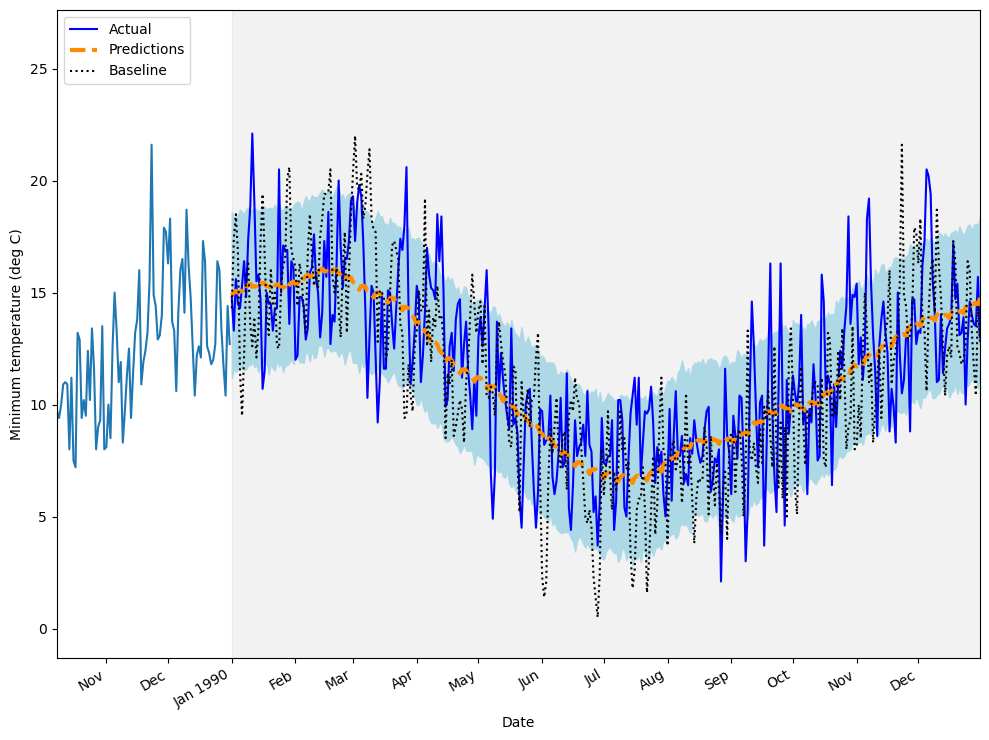

In [42]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Predictions')
ax.plot(test['baseline'], 'k:', label='Baseline')

ax.set_xlabel('Date')
ax.set_ylabel('Minimum temperature (deg C)')

ax.axvspan(3285, 3649, color='#808080', alpha=0.1)

ax.legend(loc='best')

plt.xticks(
    [3224, 3254, 3285, 3316, 3344, 3375, 3405, 3436, 3466, 3497, 3528, 3558, 3589, 3619],
    ['Nov', 'Dec', 'Jan 1990', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
plt.xlim(3200, 3649)

fig.autofmt_xdate()
plt.tight_layout()

We see that the Prophet forecast looks more like a curve-fitting procedure, since its forecast, shown as a dashed line, is a smooth curve that seems to filter the noisier fluctuations in the data.

### Exploring Prophet's advanced functionalities

We have seen how easy it is to model with Prophet. However, we have only scratched the surface in terms of its functionality.
In the next part of the notebook (below), we will explore more advanced Prophet functions, such as 

* visualization features
* cross-validation and evaluation methods
* fine-tuning procedures 

#### (a) Visualization capabilities of Prophet

Plotting our predictions using Prophet. The black dots represent the training data, while the solid continuous line represents 
the model’s predictions. The shaded band surrounding the line represents an 80% confidence interval.

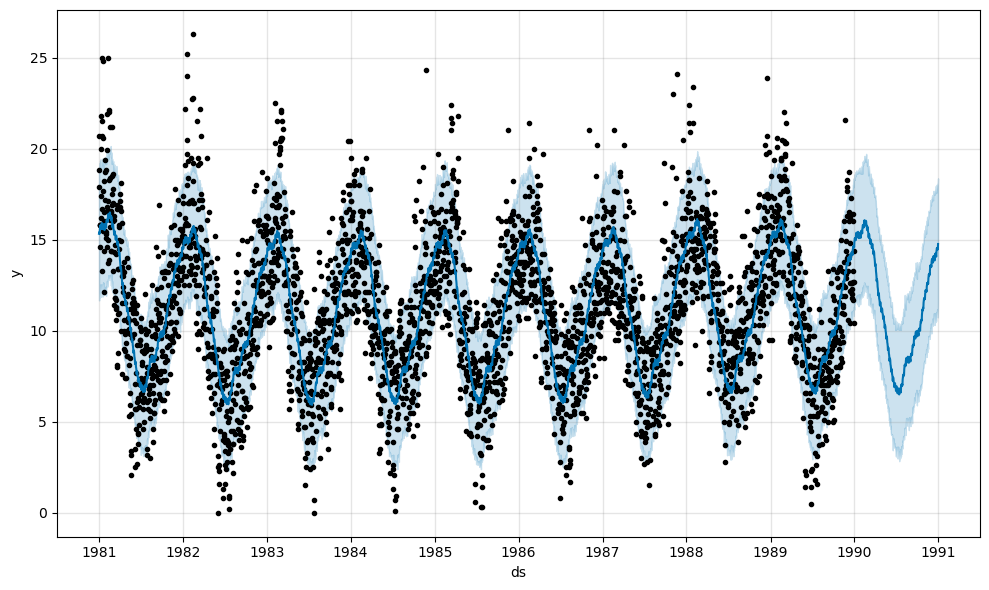

In [43]:
fig1 = m.plot(forecast)

##### Plot components 

The top plot shows the trend component, as well as the uncertainty in the trend for the forecast period. 
Looking closely, you will see that the trend changes over time, with there being six (!) different trends. 
We will explore that in more detail later further down.

The two bottom plots show two different seasonal components: 
* one with a weekly period
* the other with a yearly period. 

The yearly seasonality makes sense, as the summer months (December to February, since Australia is in the southern
hemisphere) see hotter temperatures than the winter months (June to August).

However, the weekly seasonal component is really odd. While it may help the model produce a better forecast, 
we can doubt that there is a meteorological phenomenon that can explain weekly seasonality in daily minimum temperatures. 

Thus, this component likely helps the model achieve a better fit and a better forecast, but it is hard to explain its presence and should be ignored by the interpreter. However, this shows why domain knowledge is super important when doing forecasts.

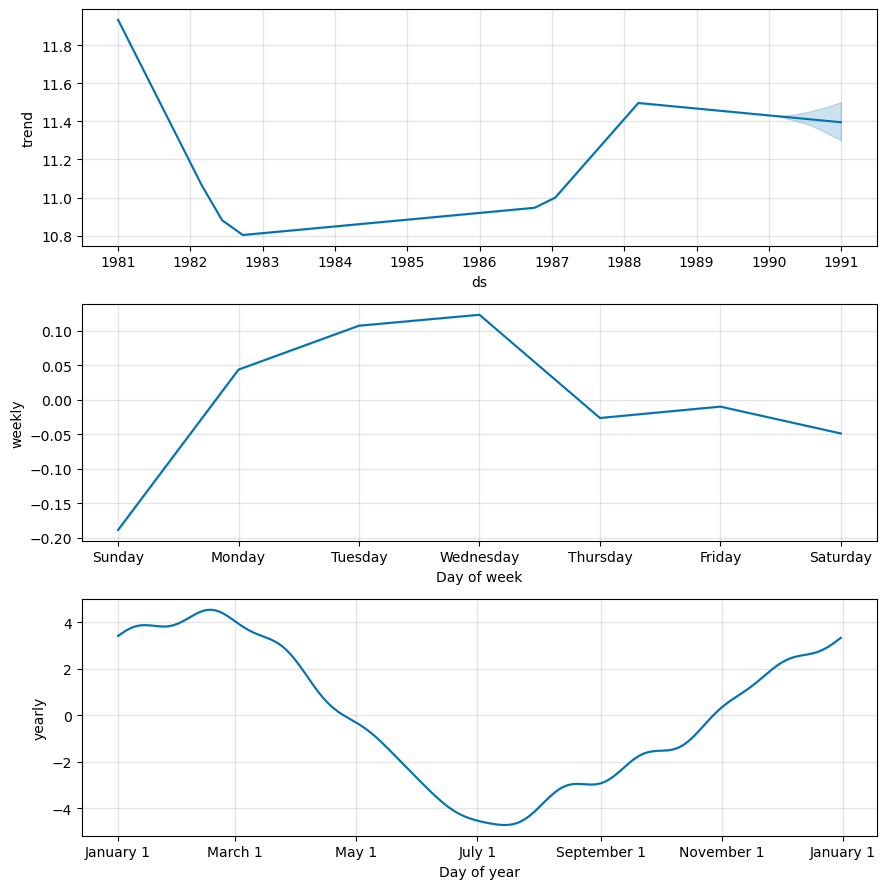

In [44]:
fig2 = m.plot_components(forecast)

##### Show trend changepoints 

Now, we want to visualize the trend changepoints in our model. Each point where the trend changes is identified by a
vertical dashed line. Notice that there were six vertical dashed lines, matching the six different trend slopes in the top plot of the components.

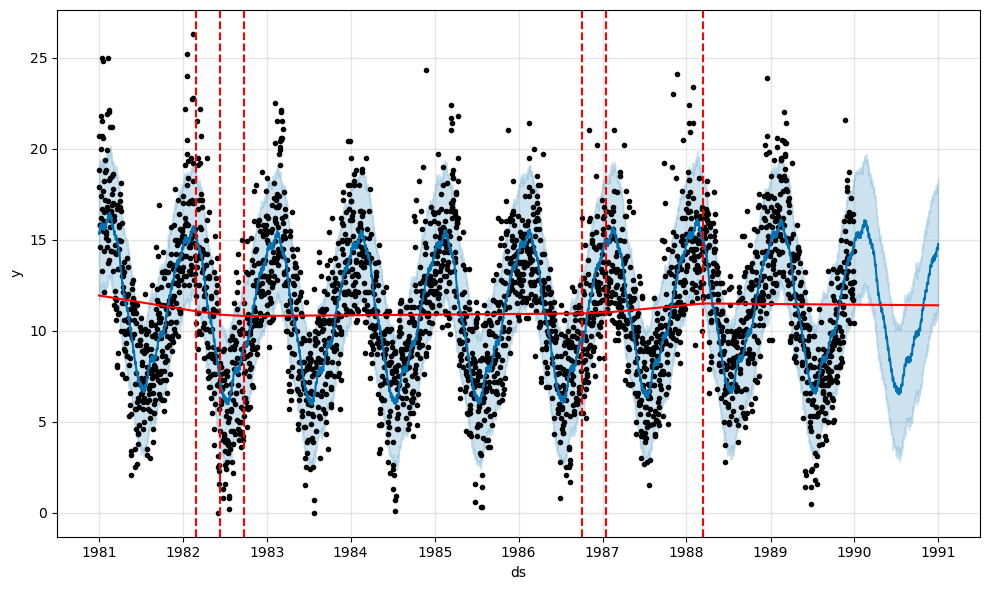

In [45]:
from prophet.plot import add_changepoints_to_plot

fig3 = m.plot(forecast)
a = add_changepoints_to_plot(fig3.gca(), m, forecast)

##### Plot seasonal components 

Also, Prophet allows us to plot only the seasonal components. Specifically, we can plot the weekly seasonality 
using the plot_weekly method or the yearly seasonality with the plot_yearly method. The result for the latter is shown below.

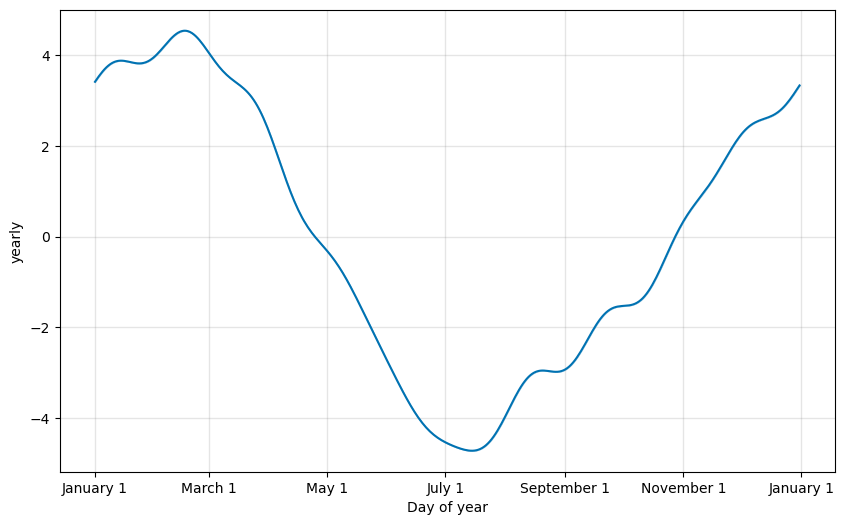

In [46]:
from prophet.plot import plot_yearly, plot_weekly

fig4 = plot_yearly(m)

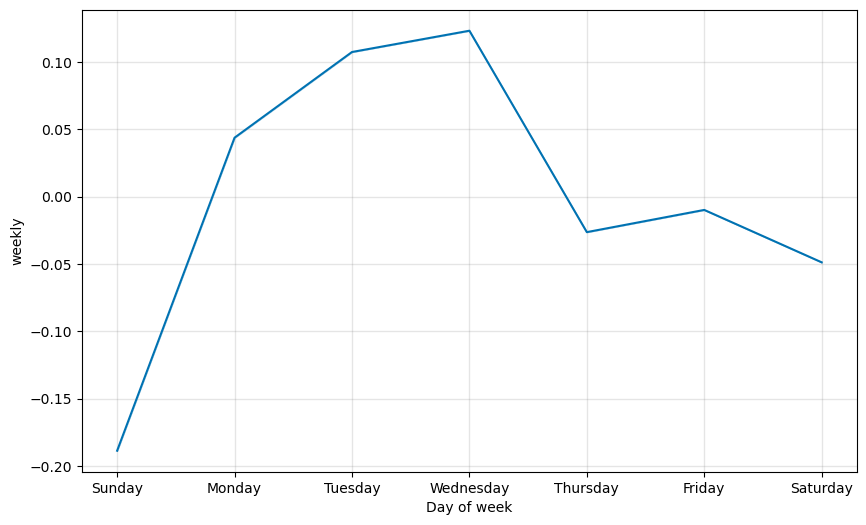

In [47]:
fig5 = plot_weekly(m)

You can recognize the yearly seasonal component of our data, as it is the same plot as the third plot in components plot. 
However, this method allows us to visualize how changing the number of terms to estimate the seasonal component can impact our model.

Remember that Prophet uses 10 terms in the Fourier series to estimate the yearly seasonality.
Now let’s visualize the seasonal component if 20 terms are used for the estimation.

11:07:28 - cmdstanpy - INFO - Chain [1] start processing
11:07:29 - cmdstanpy - INFO - Chain [1] done processing


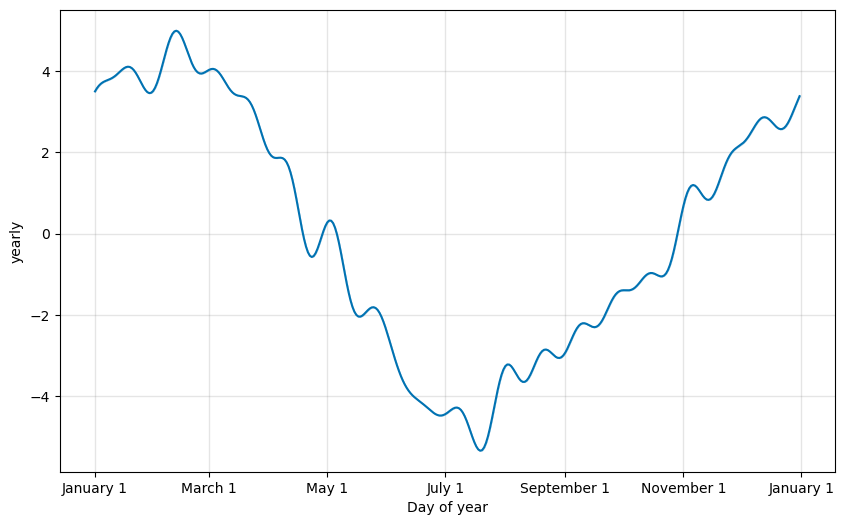

In [48]:
m2 = Prophet(yearly_seasonality=20).fit(train)

fig6 = plot_yearly(m2)

Now, the yearly seasonal component shows more fluctuation than in the plot above, meaning that it is more sensitive. 
Fine-Tuning this parameter can lead to overfitting if too many terms are used or to underfitting if we reduce the number of terms in the
Fourier series. This parameter is rarely changed, but it is interesting to see that Prophet comes with this fine-tuning functionality.

#### (b) Cross-validation and performance metrics of Prophet

After having learned the cross-validation concept from the lecture slides, we can now start implementing and using the x-validation functionality in Prophet.

* Prophet’s cross_validation function requires a Prophet model that has been fit to training data. 
* Then we must specify an initial length for the training set in the cross-validation process, denoted as initial. 
* The next parameter is the length of time separating each cutoff date, denoted as period. 
* Finally, we must specify the horizon of the forecast, denoted as horizon. 

These three parameters must have units that are compatible with the pandas.Timedelta class! 
The largest unit is days and the smallest units is in nanoseconds. Of course, anything in between, such as hours, minutes, seconds,
or milliseconds, will work as well.

By default, Prophet uses horizon to determine the length of initial and period. It sets initial to three times the length of horizon and period to half the length of
horizon. 

However, we can tweak this behavior to meet our needs.

Let’s start with an initial training period of 730 days, which represents two years of data. The horizon will be 365 days and each cutoff date will be separated by 180 days,
which is roughly half a year. Given our training set size, our cross-validation procedure has 13 steps. The output of the procedure is a DataFrame with the datestamp, the forecast,
its upper and lower bounds, the actual value and the cutoff date.

In [49]:
from prophet.diagnostics import cross_validation

# parameter settings (see above) : m is our model from above
df_xval = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel='processes')

df_xval.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1983-02-02,15.158860,11.494578,18.982207,17.3,1983-02-01
1,1983-02-03,14.820476,11.105973,18.452108,13.0,1983-02-01
2,1983-02-04,15.215519,11.605545,18.907450,16.0,1983-02-01
3,1983-02-05,15.206575,11.724716,18.746503,14.9,1983-02-01
4,1983-02-06,15.253502,11.704252,18.664004,16.2,1983-02-01


With cross-validation done, we can use the performance_metrics function to evaluate the performance of the model over the multiple forecasting periods. 
Pass in the output of cross-validation and set the rolling_window parameter. This parameter determines the portion of data over which you want to compute the
error metric. 

Setting it to 0 means that each evaluation metric is computed for each forecast point. 
Setting it to 1 averages the evaluation metrics over the entire horizon. 

In [50]:
from prophet.diagnostics import performance_metrics

df_xval_perf = performance_metrics(df_xval, rolling_window=0)

df_xval_perf.head()

,horizon,mse,rmse,mae,mdape,smape,coverage
0,1 days,6.329760,2.515901,2.066473,0.147152,0.197541,0.846154
1,2 days,4.650714,2.156551,1.741616,0.140037,0.161148,0.846154
2,3 days,10.010190,3.163888,2.656778,0.146561,0.371399,0.769231
3,4 days,8.657074,2.942291,2.373914,0.195820,0.328566,0.769231
4,5 days,8.243123,2.871084,2.569961,0.195986,0.301182,0.615385


The first five rows of the evaluation DataFrame shows the different performance metrics over different horizons, allowing us to visualize how the performance varies according to the horizon.

Finally, we can visualize the evolution of an evaluation metric over the horizon. This allows us to determine whether the error increases as the model predicts further
in time or if it remains relatively stable. Again, we’ll use the MAE, as this is how we first evaluated the model.

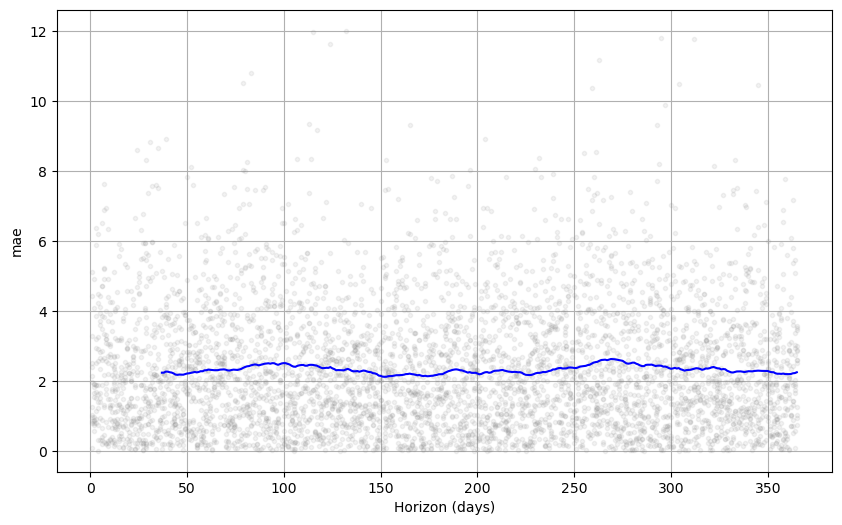

In [51]:
from prophet.plot import plot_cross_validation_metric

fig7 = plot_cross_validation_metric(df_xval, metric='mae')

The chart shows the evolution of the MAE over the forecasting horizon. 
Each dot represents the absolute error for one of the 13 forecast periods, while the solid line averages them over time. 
The line is fairly flat, meaning that we have a stable model where the error does not increase as it predicts further in time. This means we have found a stable and robust model.

#### (c) Hyperparameter tuning 

The remainder of this notebook deals with finetuning the hyperparameters of the Prophet model. In fact we can combine the search for best hyperparameters with the cross-validation functionalities of Prophet.

Four parameters are usually tuned. 

* changepoint_prior_scale, 
* seasonality_prior_scale, 
* holidays_prior_scale
* seasonality_mode. 

Other parameters can technically be changed, too, but they are often redundant forms of the above mentioned parameters. Let's see what they do:

* <font color = yellow>changepoint_prior_scale:</font>
    * The changepoint_prior_scale parameter is said to be the most impactful parameter in Prophet. It determines the flexibility of the trend and particularly how much the trend changes at the trend changepoints (compare with plot above). 
    * If the parameter is too small, the trend will underfit and the variance observed in the data will be treated as noise. 
    * If it is set too high, the trend will overfit to noisy fluctuations. 
    * Using the range [0.001, 0.01, 0.1, 0.5] is usually enough to have a well-fitted model.

* <font color = yellow>seasonality_prior_scale:</font>
    * The seasonality_prior_scale parameter sets the flexibility of the seasonality. 
    * A large value allows the seasonal component to fit smaller fluctuations, while a small value will result in a smoother seasonal component.
    * Using the range [0.01, 0.1, 1.0, 10.0] generally works well to find a good model.

* <font color = yellow>holidays_prior_scale:</font>
    * The holidays_prior_scale parameter sets the flexibility of the holiday effects and works just like the seasonality_prior_scale. 
    * It can be tuned using the same range, [0.01, 0.1, 1.0, 10.0]
    
* <font color = yellow>seasonality_mode:</font>
    * The seasonality_mode parameter can be either additive or multiplicative. By default, it is additive, but it can be set to multiplicative if you see that the seasonal fluctuation gets larger over time. 
    * This can be observed by plotting the time series, but when in doubt, you can include it in the hyperparameter tuning process. 
    * Our current dataset of historical daily minimum temperature is a great example of additive seasonality, as the yearly fluctuations do not increase over time. 

We’ll use only changepoint_prior_scale and seasonality_prior_scale in our case, since we do not have any holiday effects and our seasonal component is additive.
Let's perform a grod search and combone it with x-validation. 

In [52]:
from itertools import product

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

maes = []

for params in all_params:
    m = Prophet(**params).fit(train)
    df_xval = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel='processes')
    df_xval_perf = performance_metrics(df_xval, rolling_window=1) # average over each horizon -> speedup
    maes.append(df_xval_perf['mae'].values[0])
    
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes

tuning_results

11:07:53 - cmdstanpy - INFO - Chain [1] start processing
11:07:53 - cmdstanpy - INFO - Chain [1] done processing
11:07:57 - cmdstanpy - INFO - Chain [1] start processing
11:07:57 - cmdstanpy - INFO - Chain [1] done processing
11:08:01 - cmdstanpy - INFO - Chain [1] start processing
11:08:01 - cmdstanpy - INFO - Chain [1] done processing
11:08:05 - cmdstanpy - INFO - Chain [1] start processing
11:08:05 - cmdstanpy - INFO - Chain [1] done processing
11:08:08 - cmdstanpy - INFO - Chain [1] start processing
11:08:09 - cmdstanpy - INFO - Chain [1] done processing
11:08:12 - cmdstanpy - INFO - Chain [1] start processing
11:08:12 - cmdstanpy - INFO - Chain [1] done processing
11:08:15 - cmdstanpy - INFO - Chain [1] start processing
11:08:15 - cmdstanpy - INFO - Chain [1] done processing
11:08:18 - cmdstanpy - INFO - Chain [1] start processing
11:08:18 - cmdstanpy - INFO - Chain [1] done processing
11:08:21 - cmdstanpy - INFO - Chain [1] start processing
11:08:22 - cmdstanpy - INFO - Chain [1]

,changepoint_prior_scale,seasonality_prior_scale,mae
0,0.001,0.01,2.312238
1,0.001,0.10,2.300298
2,0.001,1.00,2.343322
3,0.001,10.00,2.340889
4,0.010,0.01,2.241216
5,0.010,0.10,2.277948
6,0.010,1.00,2.277394
7,0.010,10.00,2.280966
8,0.100,0.01,2.694213
9,0.100,0.10,2.348224


In [54]:
# take the minimum mae and print out the corresponding parameters
best_params = all_params[np.argmin(maes)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


# Implementing a forecasting example with Prophet 
## Forecasting example: Predicting the popularity of "chocolate" searches on Google 

Source: https://trends.google.com/trends/explore?date=all&geo=US&q=chocolate

For this example, we will try to predict the popularity of the search term “chocolate” on Google. 
Predicting the popularity of search terms can help marketing teams better optimize their bidding for a particular keyword, which of course impacts the CPC (cost-per-click) on an ad, 
ultimately affecting the entire return on investment of a marketing campaign. 

It can also give insight into consumer behavior. For example, if we knew that next month is likely to see a surge in people searching for chocolate, it could make sense for a chocolate 
shop to offer discounts and ensure that they have enough supply to meet the demand.

OK, let's go.

In [55]:
df = pd.read_csv('./data/FM/trend_chocolate_searches.csv')
df.head()

,month,chocolate
0,2004-01,35
1,2004-02,48
2,2004-03,34
3,2004-04,33
4,2004-05,33


In [56]:
df.tail()

,month,chocolate
211,2021-08,45
212,2021-09,45
213,2021-10,44
214,2021-11,54
215,2021-12,74


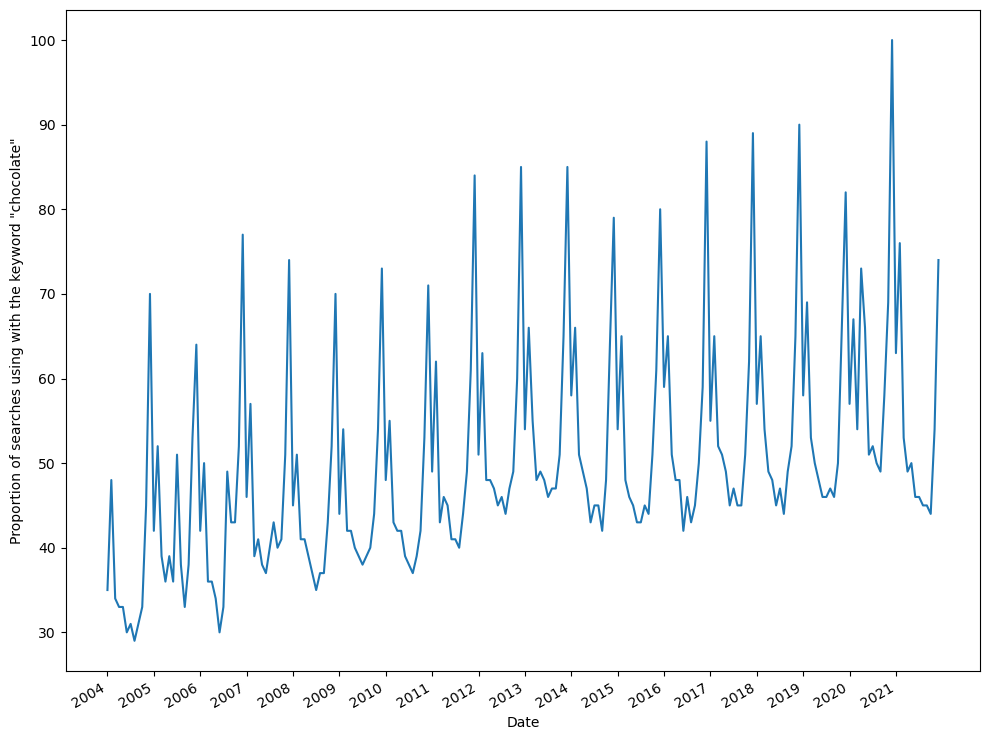

In [57]:
fig, ax = plt.subplots()

ax.plot(df['chocolate'])
ax.set_xlabel('Date')
ax.set_ylabel('Proportion of searches using with the keyword "chocolate"')

plt.xticks(np.arange(0, 215, 12), np.arange(2004, 2022, 1))

fig.autofmt_xdate()
plt.tight_layout()

In [58]:
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2004-01,35
1,2004-02,48
2,2004-03,34
3,2004-04,33
4,2004-05,33


In [59]:
from pandas.tseries.offsets import MonthEnd

df['ds'] = pd.to_datetime(df['ds']) + MonthEnd(1)

df.head()

,ds,y
0,2004-01-31,35
1,2004-02-29,48
2,2004-03-31,34
3,2004-04-30,33
4,2004-05-31,33


In [60]:
train = df[:-12]
test = df[-12:]

In [61]:
train.tail()

,ds,y
199,2020-08-31,50
200,2020-09-30,49
201,2020-10-31,58
202,2020-11-30,69
203,2020-12-31,100


In [63]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

mses = []

cutoffs = pd.date_range(start='2009-01-31', end='2019-01-31', freq='12M')

for param in params:
    m = Prophet(**param)
    m.add_country_holidays(country_name='US')
    m.fit(train)
    
    df_cv = cross_validation(model=m, horizon='365 days', cutoffs=cutoffs)
    df_p = performance_metrics(df_cv, rolling_window=1)
    mses.append(df_p['mse'].values[0])
    
tuning_results = pd.DataFrame(params)
tuning_results['mse'] = mses

11:21:52 - cmdstanpy - INFO - Chain [1] start processing
11:21:52 - cmdstanpy - INFO - Chain [1] done processing
11:21:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:21:52 - cmdstanpy - INFO - Chain [1] start processing
11:21:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/11 [00:00<?, ?it/s]

11:21:53 - cmdstanpy - INFO - Chain [1] start processing
11:21:53 - cmdstanpy - INFO - Chain [1] done processing
11:21:53 - cmdstanpy - INFO - Chain [1] start processing
11:21:55 - cmdstanpy - INFO - Chain [1] done processing
11:21:55 - cmdstanpy - INFO - Chain [1] start processing
11:21:56 - cmdstanpy - INFO - Chain [1] done processing
11:21:56 - cmdstanpy - INFO - Chain [1] start processing
11:21:56 - cmdstanpy - INFO - Chain [1] done processing
11:21:57 - cmdstanpy - INFO - Chain [1] start processing
11:21:57 - cmdstanpy - INFO - Chain [1] done processing
11:21:57 - cmdstanpy - INFO - Chain [1] start processing
11:21:57 - cmdstanpy - INFO - Chain [1] done processing
11:21:57 - cmdstanpy - INFO - Chain [1] start processing
11:21:57 - cmdstanpy - INFO - Chain [1] done processing
11:21:58 - cmdstanpy - INFO - Chain [1] start processing
11:21:58 - cmdstanpy - INFO - Chain [1] done processing
11:21:58 - cmdstanpy - INFO - Chain [1] start processing
11:21:58 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

11:22:00 - cmdstanpy - INFO - Chain [1] start processing
11:22:00 - cmdstanpy - INFO - Chain [1] done processing
11:22:00 - cmdstanpy - INFO - Chain [1] start processing
11:22:00 - cmdstanpy - INFO - Chain [1] done processing
11:22:01 - cmdstanpy - INFO - Chain [1] start processing
11:22:01 - cmdstanpy - INFO - Chain [1] done processing
11:22:01 - cmdstanpy - INFO - Chain [1] start processing
11:22:02 - cmdstanpy - INFO - Chain [1] done processing
11:22:02 - cmdstanpy - INFO - Chain [1] start processing
11:22:02 - cmdstanpy - INFO - Chain [1] done processing
11:22:02 - cmdstanpy - INFO - Chain [1] start processing
11:22:02 - cmdstanpy - INFO - Chain [1] done processing
11:22:02 - cmdstanpy - INFO - Chain [1] start processing
11:22:02 - cmdstanpy - INFO - Chain [1] done processing
11:22:03 - cmdstanpy - INFO - Chain [1] start processing
11:22:03 - cmdstanpy - INFO - Chain [1] done processing
11:22:03 - cmdstanpy - INFO - Chain [1] start processing
11:22:03 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

11:22:05 - cmdstanpy - INFO - Chain [1] start processing
11:22:06 - cmdstanpy - INFO - Chain [1] done processing
11:22:06 - cmdstanpy - INFO - Chain [1] start processing
11:22:06 - cmdstanpy - INFO - Chain [1] done processing
11:22:06 - cmdstanpy - INFO - Chain [1] start processing
11:22:06 - cmdstanpy - INFO - Chain [1] done processing
11:22:07 - cmdstanpy - INFO - Chain [1] start processing
11:22:07 - cmdstanpy - INFO - Chain [1] done processing
11:22:07 - cmdstanpy - INFO - Chain [1] start processing
11:22:07 - cmdstanpy - INFO - Chain [1] done processing
11:22:07 - cmdstanpy - INFO - Chain [1] start processing
11:22:08 - cmdstanpy - INFO - Chain [1] done processing
11:22:08 - cmdstanpy - INFO - Chain [1] start processing
11:22:08 - cmdstanpy - INFO - Chain [1] done processing
11:22:08 - cmdstanpy - INFO - Chain [1] start processing
11:22:08 - cmdstanpy - INFO - Chain [1] done processing
11:22:08 - cmdstanpy - INFO - Chain [1] start processing
11:22:08 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

11:22:10 - cmdstanpy - INFO - Chain [1] start processing
11:22:10 - cmdstanpy - INFO - Chain [1] done processing
11:22:10 - cmdstanpy - INFO - Chain [1] start processing
11:22:11 - cmdstanpy - INFO - Chain [1] done processing
11:22:11 - cmdstanpy - INFO - Chain [1] start processing
11:22:12 - cmdstanpy - INFO - Chain [1] done processing
11:22:12 - cmdstanpy - INFO - Chain [1] start processing
11:22:12 - cmdstanpy - INFO - Chain [1] done processing
11:22:12 - cmdstanpy - INFO - Chain [1] start processing
11:22:13 - cmdstanpy - INFO - Chain [1] done processing
11:22:13 - cmdstanpy - INFO - Chain [1] start processing
11:22:13 - cmdstanpy - INFO - Chain [1] done processing
11:22:13 - cmdstanpy - INFO - Chain [1] start processing
11:22:13 - cmdstanpy - INFO - Chain [1] done processing
11:22:13 - cmdstanpy - INFO - Chain [1] start processing
11:22:13 - cmdstanpy - INFO - Chain [1] done processing
11:22:14 - cmdstanpy - INFO - Chain [1] start processing
11:22:14 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

11:22:15 - cmdstanpy - INFO - Chain [1] start processing
11:22:15 - cmdstanpy - INFO - Chain [1] done processing
11:22:15 - cmdstanpy - INFO - Chain [1] start processing
11:22:16 - cmdstanpy - INFO - Chain [1] done processing
11:22:16 - cmdstanpy - INFO - Chain [1] start processing
11:22:16 - cmdstanpy - INFO - Chain [1] done processing
11:22:16 - cmdstanpy - INFO - Chain [1] start processing
11:22:16 - cmdstanpy - INFO - Chain [1] done processing
11:22:17 - cmdstanpy - INFO - Chain [1] start processing
11:22:17 - cmdstanpy - INFO - Chain [1] done processing
11:22:17 - cmdstanpy - INFO - Chain [1] start processing
11:22:17 - cmdstanpy - INFO - Chain [1] done processing
11:22:17 - cmdstanpy - INFO - Chain [1] start processing
11:22:17 - cmdstanpy - INFO - Chain [1] done processing
11:22:18 - cmdstanpy - INFO - Chain [1] start processing
11:22:18 - cmdstanpy - INFO - Chain [1] done processing
11:22:18 - cmdstanpy - INFO - Chain [1] start processing
11:22:18 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

11:22:19 - cmdstanpy - INFO - Chain [1] start processing
11:22:19 - cmdstanpy - INFO - Chain [1] done processing
11:22:20 - cmdstanpy - INFO - Chain [1] start processing
11:22:20 - cmdstanpy - INFO - Chain [1] done processing
11:22:20 - cmdstanpy - INFO - Chain [1] start processing
11:22:21 - cmdstanpy - INFO - Chain [1] done processing
11:22:21 - cmdstanpy - INFO - Chain [1] start processing
11:22:21 - cmdstanpy - INFO - Chain [1] done processing
11:22:21 - cmdstanpy - INFO - Chain [1] start processing
11:22:21 - cmdstanpy - INFO - Chain [1] done processing
11:22:22 - cmdstanpy - INFO - Chain [1] start processing
11:22:22 - cmdstanpy - INFO - Chain [1] done processing
11:22:22 - cmdstanpy - INFO - Chain [1] start processing
11:22:22 - cmdstanpy - INFO - Chain [1] done processing
11:22:22 - cmdstanpy - INFO - Chain [1] start processing
11:22:22 - cmdstanpy - INFO - Chain [1] done processing
11:22:23 - cmdstanpy - INFO - Chain [1] start processing
11:22:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

11:22:24 - cmdstanpy - INFO - Chain [1] start processing
11:22:24 - cmdstanpy - INFO - Chain [1] done processing
11:22:24 - cmdstanpy - INFO - Chain [1] start processing
11:22:25 - cmdstanpy - INFO - Chain [1] done processing
11:22:25 - cmdstanpy - INFO - Chain [1] start processing
11:22:25 - cmdstanpy - INFO - Chain [1] done processing
11:22:26 - cmdstanpy - INFO - Chain [1] start processing
11:22:26 - cmdstanpy - INFO - Chain [1] done processing
11:22:26 - cmdstanpy - INFO - Chain [1] start processing
11:22:26 - cmdstanpy - INFO - Chain [1] done processing
11:22:26 - cmdstanpy - INFO - Chain [1] start processing
11:22:26 - cmdstanpy - INFO - Chain [1] done processing
11:22:27 - cmdstanpy - INFO - Chain [1] start processing
11:22:27 - cmdstanpy - INFO - Chain [1] done processing
11:22:27 - cmdstanpy - INFO - Chain [1] start processing
11:22:27 - cmdstanpy - INFO - Chain [1] done processing
11:22:27 - cmdstanpy - INFO - Chain [1] start processing
11:22:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

11:22:28 - cmdstanpy - INFO - Chain [1] start processing
11:22:29 - cmdstanpy - INFO - Chain [1] done processing
11:22:29 - cmdstanpy - INFO - Chain [1] start processing
11:22:29 - cmdstanpy - INFO - Chain [1] done processing
11:22:29 - cmdstanpy - INFO - Chain [1] start processing
11:22:30 - cmdstanpy - INFO - Chain [1] done processing
11:22:30 - cmdstanpy - INFO - Chain [1] start processing
11:22:30 - cmdstanpy - INFO - Chain [1] done processing
11:22:31 - cmdstanpy - INFO - Chain [1] start processing
11:22:31 - cmdstanpy - INFO - Chain [1] done processing
11:22:31 - cmdstanpy - INFO - Chain [1] start processing
11:22:31 - cmdstanpy - INFO - Chain [1] done processing
11:22:31 - cmdstanpy - INFO - Chain [1] start processing
11:22:31 - cmdstanpy - INFO - Chain [1] done processing
11:22:31 - cmdstanpy - INFO - Chain [1] start processing
11:22:32 - cmdstanpy - INFO - Chain [1] done processing
11:22:32 - cmdstanpy - INFO - Chain [1] start processing
11:22:32 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

11:22:33 - cmdstanpy - INFO - Chain [1] start processing
11:22:34 - cmdstanpy - INFO - Chain [1] done processing
11:22:34 - cmdstanpy - INFO - Chain [1] start processing
11:22:34 - cmdstanpy - INFO - Chain [1] done processing
11:22:35 - cmdstanpy - INFO - Chain [1] start processing
11:22:35 - cmdstanpy - INFO - Chain [1] done processing
11:22:35 - cmdstanpy - INFO - Chain [1] start processing
11:22:36 - cmdstanpy - INFO - Chain [1] done processing
11:22:36 - cmdstanpy - INFO - Chain [1] start processing
11:22:36 - cmdstanpy - INFO - Chain [1] done processing
11:22:36 - cmdstanpy - INFO - Chain [1] start processing
11:22:36 - cmdstanpy - INFO - Chain [1] done processing
11:22:37 - cmdstanpy - INFO - Chain [1] start processing
11:22:37 - cmdstanpy - INFO - Chain [1] done processing
11:22:37 - cmdstanpy - INFO - Chain [1] start processing
11:22:37 - cmdstanpy - INFO - Chain [1] done processing
11:22:37 - cmdstanpy - INFO - Chain [1] start processing
11:22:37 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

11:22:39 - cmdstanpy - INFO - Chain [1] start processing
11:22:39 - cmdstanpy - INFO - Chain [1] done processing
11:22:39 - cmdstanpy - INFO - Chain [1] start processing
11:22:40 - cmdstanpy - INFO - Chain [1] done processing
11:22:40 - cmdstanpy - INFO - Chain [1] start processing
11:22:40 - cmdstanpy - INFO - Chain [1] done processing
11:22:41 - cmdstanpy - INFO - Chain [1] start processing
11:22:41 - cmdstanpy - INFO - Chain [1] done processing
11:22:41 - cmdstanpy - INFO - Chain [1] start processing
11:22:41 - cmdstanpy - INFO - Chain [1] done processing
11:22:42 - cmdstanpy - INFO - Chain [1] start processing
11:22:42 - cmdstanpy - INFO - Chain [1] done processing
11:22:42 - cmdstanpy - INFO - Chain [1] start processing
11:22:42 - cmdstanpy - INFO - Chain [1] done processing
11:22:42 - cmdstanpy - INFO - Chain [1] start processing
11:22:42 - cmdstanpy - INFO - Chain [1] done processing
11:22:43 - cmdstanpy - INFO - Chain [1] start processing
11:22:43 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

11:22:44 - cmdstanpy - INFO - Chain [1] start processing
11:22:44 - cmdstanpy - INFO - Chain [1] done processing
11:22:44 - cmdstanpy - INFO - Chain [1] start processing
11:22:45 - cmdstanpy - INFO - Chain [1] done processing
11:22:45 - cmdstanpy - INFO - Chain [1] start processing
11:22:46 - cmdstanpy - INFO - Chain [1] done processing
11:22:46 - cmdstanpy - INFO - Chain [1] start processing
11:22:46 - cmdstanpy - INFO - Chain [1] done processing
11:22:46 - cmdstanpy - INFO - Chain [1] start processing
11:22:46 - cmdstanpy - INFO - Chain [1] done processing
11:22:47 - cmdstanpy - INFO - Chain [1] start processing
11:22:47 - cmdstanpy - INFO - Chain [1] done processing
11:22:47 - cmdstanpy - INFO - Chain [1] start processing
11:22:47 - cmdstanpy - INFO - Chain [1] done processing
11:22:47 - cmdstanpy - INFO - Chain [1] start processing
11:22:47 - cmdstanpy - INFO - Chain [1] done processing
11:22:48 - cmdstanpy - INFO - Chain [1] start processing
11:22:48 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

11:22:49 - cmdstanpy - INFO - Chain [1] start processing
11:22:49 - cmdstanpy - INFO - Chain [1] done processing
11:22:50 - cmdstanpy - INFO - Chain [1] start processing
11:22:50 - cmdstanpy - INFO - Chain [1] done processing
11:22:50 - cmdstanpy - INFO - Chain [1] start processing
11:22:51 - cmdstanpy - INFO - Chain [1] done processing
11:22:51 - cmdstanpy - INFO - Chain [1] start processing
11:22:52 - cmdstanpy - INFO - Chain [1] done processing
11:22:52 - cmdstanpy - INFO - Chain [1] start processing
11:22:52 - cmdstanpy - INFO - Chain [1] done processing
11:22:52 - cmdstanpy - INFO - Chain [1] start processing
11:22:52 - cmdstanpy - INFO - Chain [1] done processing
11:22:53 - cmdstanpy - INFO - Chain [1] start processing
11:22:53 - cmdstanpy - INFO - Chain [1] done processing
11:22:53 - cmdstanpy - INFO - Chain [1] start processing
11:22:53 - cmdstanpy - INFO - Chain [1] done processing
11:22:53 - cmdstanpy - INFO - Chain [1] start processing
11:22:53 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

11:22:54 - cmdstanpy - INFO - Chain [1] start processing
11:22:55 - cmdstanpy - INFO - Chain [1] done processing
11:22:55 - cmdstanpy - INFO - Chain [1] start processing
11:22:56 - cmdstanpy - INFO - Chain [1] done processing
11:22:56 - cmdstanpy - INFO - Chain [1] start processing
11:22:56 - cmdstanpy - INFO - Chain [1] done processing
11:22:56 - cmdstanpy - INFO - Chain [1] start processing
11:22:57 - cmdstanpy - INFO - Chain [1] done processing
11:22:57 - cmdstanpy - INFO - Chain [1] start processing
11:22:57 - cmdstanpy - INFO - Chain [1] done processing
11:22:58 - cmdstanpy - INFO - Chain [1] start processing
11:22:58 - cmdstanpy - INFO - Chain [1] done processing
11:22:58 - cmdstanpy - INFO - Chain [1] start processing
11:22:58 - cmdstanpy - INFO - Chain [1] done processing
11:22:58 - cmdstanpy - INFO - Chain [1] start processing
11:22:58 - cmdstanpy - INFO - Chain [1] done processing
11:22:59 - cmdstanpy - INFO - Chain [1] start processing
11:22:59 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

11:23:00 - cmdstanpy - INFO - Chain [1] start processing
11:23:01 - cmdstanpy - INFO - Chain [1] done processing
11:23:01 - cmdstanpy - INFO - Chain [1] start processing
11:23:02 - cmdstanpy - INFO - Chain [1] done processing
11:23:02 - cmdstanpy - INFO - Chain [1] start processing
11:23:02 - cmdstanpy - INFO - Chain [1] done processing
11:23:03 - cmdstanpy - INFO - Chain [1] start processing
11:23:03 - cmdstanpy - INFO - Chain [1] done processing
11:23:03 - cmdstanpy - INFO - Chain [1] start processing
11:23:04 - cmdstanpy - INFO - Chain [1] done processing
11:23:04 - cmdstanpy - INFO - Chain [1] start processing
11:23:04 - cmdstanpy - INFO - Chain [1] done processing
11:23:04 - cmdstanpy - INFO - Chain [1] start processing
11:23:04 - cmdstanpy - INFO - Chain [1] done processing
11:23:04 - cmdstanpy - INFO - Chain [1] start processing
11:23:05 - cmdstanpy - INFO - Chain [1] done processing
11:23:05 - cmdstanpy - INFO - Chain [1] start processing
11:23:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

11:23:06 - cmdstanpy - INFO - Chain [1] start processing
11:23:07 - cmdstanpy - INFO - Chain [1] done processing
11:23:07 - cmdstanpy - INFO - Chain [1] start processing
11:23:08 - cmdstanpy - INFO - Chain [1] done processing
11:23:08 - cmdstanpy - INFO - Chain [1] start processing
11:23:09 - cmdstanpy - INFO - Chain [1] done processing
11:23:09 - cmdstanpy - INFO - Chain [1] start processing
11:23:10 - cmdstanpy - INFO - Chain [1] done processing
11:23:10 - cmdstanpy - INFO - Chain [1] start processing
11:23:10 - cmdstanpy - INFO - Chain [1] done processing
11:23:10 - cmdstanpy - INFO - Chain [1] start processing
11:23:10 - cmdstanpy - INFO - Chain [1] done processing
11:23:10 - cmdstanpy - INFO - Chain [1] start processing
11:23:11 - cmdstanpy - INFO - Chain [1] done processing
11:23:11 - cmdstanpy - INFO - Chain [1] start processing
11:23:11 - cmdstanpy - INFO - Chain [1] done processing
11:23:11 - cmdstanpy - INFO - Chain [1] start processing
11:23:11 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/11 [00:00<?, ?it/s]

11:23:12 - cmdstanpy - INFO - Chain [1] start processing
11:23:13 - cmdstanpy - INFO - Chain [1] done processing
11:23:13 - cmdstanpy - INFO - Chain [1] start processing
11:23:14 - cmdstanpy - INFO - Chain [1] done processing
11:23:14 - cmdstanpy - INFO - Chain [1] start processing
11:23:15 - cmdstanpy - INFO - Chain [1] done processing
11:23:15 - cmdstanpy - INFO - Chain [1] start processing
11:23:16 - cmdstanpy - INFO - Chain [1] done processing
11:23:16 - cmdstanpy - INFO - Chain [1] start processing
11:23:16 - cmdstanpy - INFO - Chain [1] done processing
11:23:16 - cmdstanpy - INFO - Chain [1] start processing
11:23:16 - cmdstanpy - INFO - Chain [1] done processing
11:23:17 - cmdstanpy - INFO - Chain [1] start processing
11:23:17 - cmdstanpy - INFO - Chain [1] done processing
11:23:17 - cmdstanpy - INFO - Chain [1] start processing
11:23:17 - cmdstanpy - INFO - Chain [1] done processing
11:23:17 - cmdstanpy - INFO - Chain [1] start processing
11:23:17 - cmdstanpy - INFO - Chain [1]

In [64]:
best_params = params[np.argmin(mses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


In [65]:
m = Prophet(**best_params)
m.add_country_holidays(country_name='US')
m.fit(train);

11:23:20 - cmdstanpy - INFO - Chain [1] start processing
11:23:20 - cmdstanpy - INFO - Chain [1] done processing


In [66]:
future = m.make_future_dataframe(periods=12, freq='M')

In [67]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
204,2021-01-31,60.808736,56.218570,64.927620
205,2021-02-28,70.099219,65.647491,74.696435
206,2021-03-31,56.329244,51.765160,60.942357
207,2021-04-30,56.201505,51.408612,60.739411
208,2021-05-31,53.407596,49.109171,58.382545
209,2021-06-30,51.293729,46.963625,55.810292
210,2021-07-31,53.007382,48.680098,57.535755
211,2021-08-31,52.711547,48.041747,57.278483
212,2021-09-30,52.739451,48.334003,57.502369
213,2021-10-31,56.985452,52.667375,61.444569


In [68]:
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
test.head()

,ds,y,yhat,yhat_lower,yhat_upper
204,2021-01-31,63,60.808736,56.218570,64.927620
205,2021-02-28,76,70.099219,65.647491,74.696435
206,2021-03-31,53,56.329244,51.765160,60.942357
207,2021-04-30,49,56.201505,51.408612,60.739411
208,2021-05-31,50,53.407596,49.109171,58.382545


In [69]:
test['baseline'] = train['y'][-12:].values
test.head()

,ds,y,yhat,yhat_lower,yhat_upper,baseline
204,2021-01-31,63,60.808736,56.218570,64.927620,57
205,2021-02-28,76,70.099219,65.647491,74.696435,67
206,2021-03-31,53,56.329244,51.765160,60.942357,54
207,2021-04-30,49,56.201505,51.408612,60.739411,73
208,2021-05-31,50,53.407596,49.109171,58.382545,66


In [70]:
prophet_mae = mean_absolute_error(test['y'], test['yhat'])
baseline_mae = mean_absolute_error(test['y'], test['baseline'])

print(prophet_mae)
print(baseline_mae)

7.393462858774003
10.916666666666666


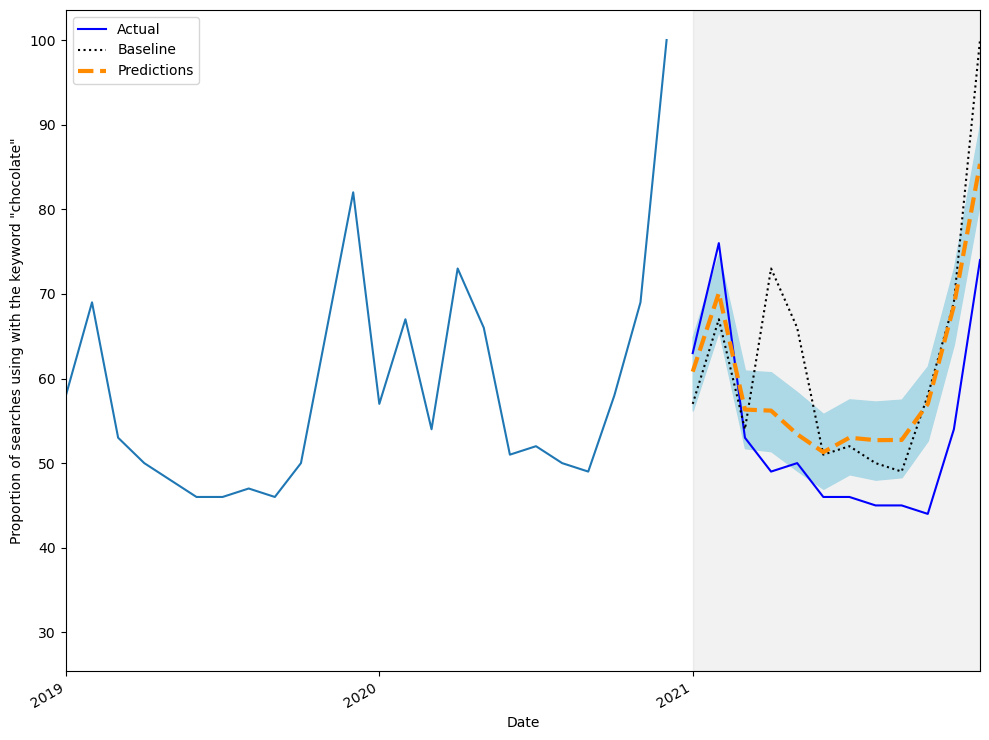

In [71]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['baseline'], 'k:', label='Baseline')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Predictions')

ax.set_xlabel('Date')
ax.set_ylabel('Proportion of searches using with the keyword "chocolate"')

ax.axvspan(204, 215, color='#808080', alpha=0.1)

ax.legend(loc='best')

plt.xticks(np.arange(0, 215, 12), np.arange(2004, 2022, 1))
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
plt.xlim(180, 215)

fig.autofmt_xdate()
plt.tight_layout()

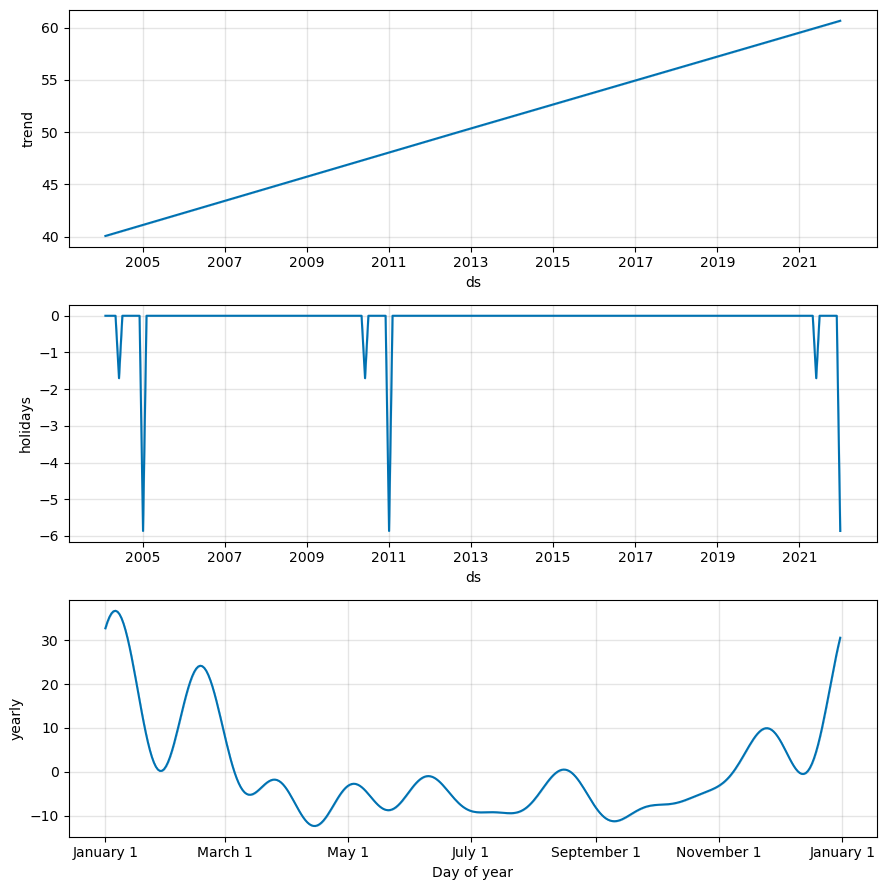

In [72]:
prophet_components_fig = m.plot_components(forecast)

## Forecasting example: Predicting the popularity of "chocolate" searches on Google 
### What about a SARIMA models performance on the same data set? 

In [12]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

In [13]:
ad_fuller_result = adfuller(df['y'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.0341743396012566
p-value: 0.27179271331669047


In [14]:
y_diff = np.diff(df['y'], n=1)

ad_fuller_result = adfuller(y_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -7.034710505102216
p-value: 6.058003360041225e-10


$d=1$, $D=0$ and $m=12$

In [15]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [16]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 0
s = 12

In [17]:
SARIMA_result_df = optimize_SARIMAX(train['y'], None, order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

C:\Users\gheisenb\AppData\Local\anaconda3\envs\prophetenv_man\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\gheisenb\AppData\Local\anaconda3\envs\prophetenv_man\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\gheisenb\AppData\Local\anaconda3\envs\prophetenv_man\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\gheisenb\AppData\Local\anaconda3\envs\prophetenv_man\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

,"(p,q,P,Q)",AIC
0,"(1, 0, 3, 1)",12.000000
1,"(0, 3, 3, 1)",64.186681
2,"(1, 1, 1, 1)",1127.747197
3,"(1, 2, 1, 1)",1128.795724
4,"(2, 1, 1, 1)",1129.480114
...,...,...
248,"(1, 2, 0, 0)",1570.730422
249,"(2, 1, 0, 0)",1570.732139
250,"(0, 1, 0, 0)",1570.979692
251,"(0, 2, 0, 0)",1571.866177


In [18]:
SARIMA_model = SARIMAX(train['y'], order=(1,1,1), seasonal_order=(1,0,1,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -558.874
Date:                            Wed, 11 Jun 2025   AIC                           1127.747
Time:                                    11:05:30   BIC                           1144.313
Sample:                                         0   HQIC                          1134.449
                                            - 204                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3577      0.081      4.432      0.000       0.200       0.516
ma.L1         -0.8938      0.055   

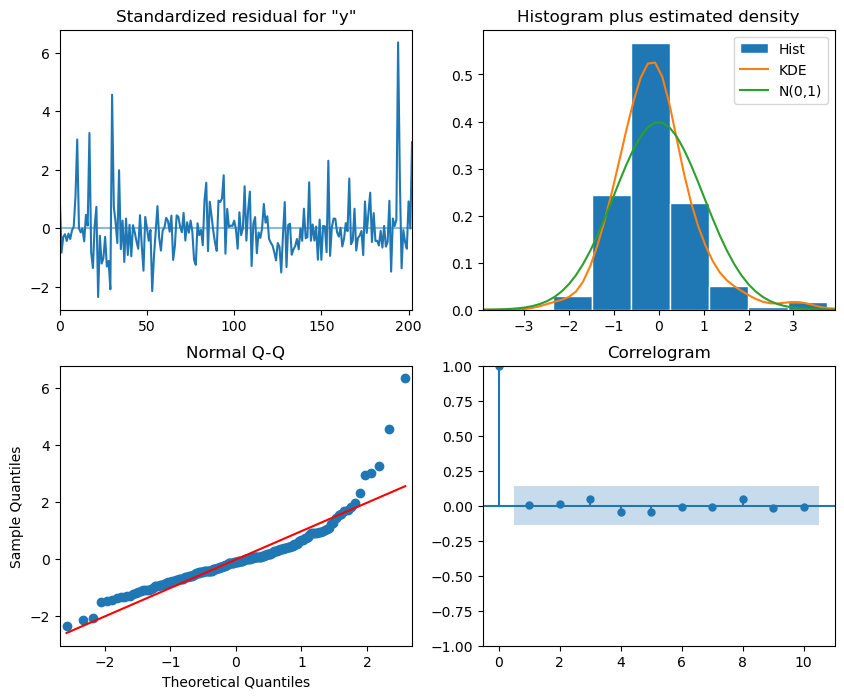

In [19]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [20]:
residuals = SARIMA_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [21]:
test

,ds,y
204,2021-01-31,63
205,2021-02-28,76
206,2021-03-31,53
207,2021-04-30,49
208,2021-05-31,50
209,2021-06-30,46
210,2021-07-31,46
211,2021-08-31,45
212,2021-09-30,45
213,2021-10-31,44


In [22]:
SARIMA_pred = SARIMA_model_fit.get_prediction(204, 215).predicted_mean

test['SARIMA_pred'] = SARIMA_pred

test

,ds,y,SARIMA_pred
204,2021-01-31,63,66.618129
205,2021-02-28,76,74.237208
206,2021-03-31,53,59.779492
207,2021-04-30,49,60.525881
208,2021-05-31,50,58.473771
209,2021-06-30,46,53.719874
210,2021-07-31,46,55.001704
211,2021-08-31,45,54.306774
212,2021-09-30,45,54.589820
213,2021-10-31,44,59.552760


In [25]:
SARIMA_mae = mean_absolute_error(test['y'], test['SARIMA_pred'])

print(SARIMA_mae)

10.090589396447523


SARIMA achieves an MAE = 10.09. Remember that our Prophet model had an MAE of 7.42 and the baseline achieved an MAE of 10.92.

Hence, it is better than the baseline, but it does not beat Prophet in this case. 